# Step 3 - Climate Analysis and Exploration

In [71]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

startDate='2018-05-25'
endDate='2018-05-30'

In [72]:
# function definitions
def isDate(date, checker=False):
    if len(date.split('-')) == 3 and len(date.split('-')[0]) == 4 and len(date.split('-')[1]) == 2 and len(date.split('-')[2]) == 2:
        checker = True
    else:
        print(f'Please enter date correctly! YYYY-MM-DD')
    return checker

def yearAgoDate(date):
    if isDate(date):
        Year = int(date.split('-')[0])
        Month = int(date.split('-')[1])
        Day = int(date.split('-')[2])
    return dt.date(Year-1, Month, Day)

In [75]:
# Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
# function definition
def setDate(dateType, isCorrect=False):
#     print(isCorrect)
    while not isCorrect:
        if dateType == 'dept':
            startDate = input(f'Please enter your departure date YYYY-MM-DD: ')
            isCorrect = isDate(startDate)
            return startDate
        elif dateType == 'arr':
            endDate = input(f'Please enter your arriving date YYYY-MM-DD: ')
            isCorrect = isDate(endDate)
            return endDate
        else:
            print('wrong date type: use dept or arr')

In [76]:
# set Dates
print("Let's start trip planning!")
startDate = setDate('dept')

Let's start trip planning!
Please enter your departure date YYYY-MM-DD: 2018-01-02
2018-01-02


In [46]:
endDate = setDate('arr')

Please enter your arriving date YYYY-MM-DD: 2018-05-30


In [47]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [48]:
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [49]:
# Get a list of column names and types
ms_columns = inspector.get_columns('measurements')
for c in ms_columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [50]:
st_columns = inspector.get_columns('stations')
for c in st_columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longtitude FLOAT
elevation FLOAT


In [51]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
Base = automap_base()
Base.prepare(engine, reflect=True)
Mea = Base.classes.measurements
Sta = Base.classes.stations

In [52]:
session = Session(engine)

In [53]:
session.query(func.count(Mea.date)).all()

[(18103)]

In [54]:
session.query(func.count(Sta.name)).all()

[(9)]

## Precipitation Analysis

In [55]:
# get the latest date in Measurement
latest = session.query(Mea.date).order_by(Mea.date.desc()).first()[0]
lYear = int(latest.split('-')[0])
lMonth = int(latest.split('-')[1])
lDay = int(latest.split('-')[2])

latestDate = dt.date(lYear, lMonth, lDay)

# get a year ago data from latestDate
yearAgoDate = dt.date(lYear-1, lMonth, lDay)

# Design a query to retrieve the last 12 months of precipitation data
# Select only the date and prcp values
# Load the query results into a Pandas DataFrame
prcp = pd.read_sql(session.query(Mea.date, Mea.prcp).filter(Mea.date > yearAgoDate, Mea.date <= latestDate).order_by(Mea.date).statement, session.bind)
# prcp

In [56]:
# set date as datetime
prcp['date']=pd.to_datetime(prcp['date'])
type(prcp.loc[0,'date'])

pandas._libs.tslib.Timestamp

/Users/tokunaga/.pyenv/versions/anaconda3-5.0.0/envs/PythonData/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


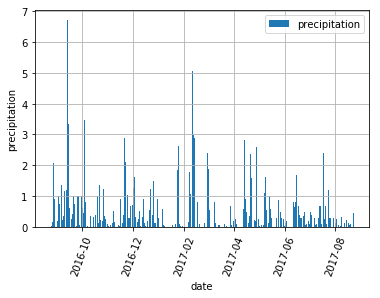

In [57]:
# draw a plot

# set the index to the date column.
prcp_i = prcp.set_index('date')

%matplotlib inline
p1 = plt.bar(prcp_i.index, prcp_i['prcp'])
# p1 = plt.scatter(prcp_i.index, prcp_i['prcp'])
plt.xticks(rotation=70)
plt.legend([p1],['precipitation'])

ax=plt.subplot()
ax.set_xlabel('date')
ax.set_ylabel('precipitation')

ax.grid()
# ax.set_xlim(['2017-01-01','2017-12-31'])

plt.show()

In [58]:
# Use Pandas to print the summary statistics for the precipitation data.
prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [59]:
# Design a query to calculate the total number of stations.
session.query(func.count(Sta.name)).all()

[(9)]

In [60]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order
sel = [Sta.name, Mea.station, Mea.date, Mea.prcp, Mea.tobs]

st_DF=pd.read_sql(session.query(*sel).filter(Mea.station == Sta.station).order_by(Mea.date).statement, session.bind)
st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station']

# Which station has the highest number of observations?
highestSt = st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station'].index[0]
highestCnt = st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station'][0]

# print results
print(f'{highestSt} has The highest number of observations, the observation count is {highestCnt}.')

WAIHEE 837.5, HI US has The highest number of observations, the observation count is 2772.


/Users/tokunaga/.pyenv/versions/anaconda3-5.0.0/envs/PythonData/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


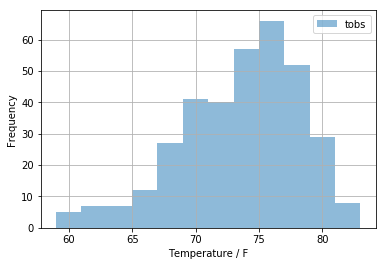

In [61]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
tobs_past12 = pd.read_sql(session.query(Mea.date, Sta.name, Mea.tobs).filter(Mea.station == Sta.station, Mea.date > yearAgoDate, Mea.date < latestDate).order_by(Mea.date).statement, session.bind)
# tobs_past12

# Filter by the station with the highest number of observations.
tobs_past12.loc[tobs_past12['name']== highestSt]

# Plot the results as a histogram with bins=12.
tobs_past12.loc[tobs_past12['name']== highestSt].plot.hist(bins=12, alpha=0.5)
ax=plt.subplot()
ax.set_xlabel('Temperature / F')
ax.grid()

plt.show()

## Temperature Analysis

In [80]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start, end):
    if start > end:
        start_ = end
        end_ = start
    else:
        start_ = start
        end_ = end
    
    start_prev = yearAgoDate(start_)
    end_prev = yearAgoDate(end_)

    tobs_DF = pd.read_sql(session.query(Mea.date, Sta.name, Mea.tobs).filter(Mea.station == Sta.station, Mea.date > start_prev, Mea.date < end_prev).order_by(Mea.date).statement, session.bind)
    return {
        'min': tobs_DF.describe().loc[tobs_DF.describe().index=='min']['tobs'][0],
        'avg': tobs_DF.describe().loc[tobs_DF.describe().index=='mean']['tobs'][0],
        'max': tobs_DF.describe().loc[tobs_DF.describe().index=='max']['tobs'][0],
        'start_date': start_prev,
        'end_date': end_prev
    }

/Users/tokunaga/.pyenv/versions/anaconda3-5.0.0/envs/PythonData/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


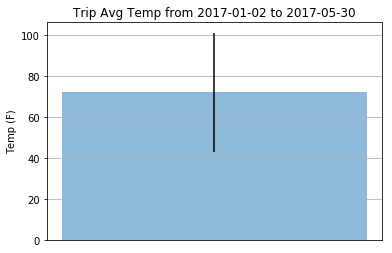

In [84]:
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
data=calc_temps(startDate, endDate)

# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
plt.bar(0,data['avg'],yerr=data['max']-data['min'], alpha=0.5)
plt.xticks([1],['avg'])
ax=plt.subplot()
ax.set_ylabel('Temp (F)')

sDate = data['start_date']
eDate = data['end_date']
plt.title(f'Trip Avg Temp from {sDate} to {eDate}')

ax.grid()
plt.show()


## Optional Recommended Analysis

In [ ]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
# Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.


# Create a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
# Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
# Use Pandas to plot an area plot (stacked=False) for the daily normals.